# XGBoost Prototype
This notebook will be used to develop a prototype machine learning model to be used for fitting the from the strain gauges for force reconstruction.
At first the prototype is going to be developed using the dataset found at https://www.kaggle.com/daalgi/fem-simulations

## Introduction
This first section introduces the general idea of what is going to be done and takes care of some housekeeping tasks like imports.
The following cell imports the libraries we need for the model

In [170]:
## Imports
import numpy as np
import pandas as pd
import xgboost as xgb
import pickle
from google.colab import files
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
import matplotlib.pyplot as plt

Now the data needs to be loaded in. We are in a colab notebook, so the data is loaded as follows from a local drive which has to have the data already in it.

In [30]:
## Loading in data
from google.colab import files
uploaded = files.upload()

Saving 5184doe.csv to 5184doe (1).csv



In the previous step, we loaded the file from the drive into the colab workspace, and now we transform it into a data type called a "dataframe" which is easy to think of essentially as an excel table, with headers and all. The library that handles the dataframe data type is pandas, shortened to "pd" in the imports. The variable that stores this data is "df".

The step of loading in the data is so simple because we are getting a dataset which is already very well formated. Whenever we get the actual dataset a lot will have to be done to pre-process it and create a dataset which is usable by the model.

In [39]:
## load data into variable
df = pd.read_csv('5184doe.csv')

# display the dataframe variable
df

,Sample,ecc,N,gammaG,Esoil,Econc,Dbot,H1,H2,H3,Mr_t,Mt_t,Mr_c,Mt_c
0,1,0,2000,0.9,25,30000,17,0.8,1.0,0.8,0.082100,0.055648,0.082100,0.055648
1,2,10,2000,0.9,25,30000,17,0.8,1.0,0.8,-0.597084,-0.233470,1.160648,0.605016
2,3,18,2000,0.9,25,30000,17,0.8,1.0,0.8,-1.094196,-0.566130,1.908188,0.947770
3,4,26,2000,0.9,25,30000,17,0.8,1.0,0.8,-1.416485,-0.865039,2.844706,1.310545
4,5,0,2000,0.9,25,37000,17,0.8,1.0,0.8,0.079570,0.054213,0.079570,0.054213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5179,5180,26,5000,1.1,75,30000,23,1.6,2.0,1.6,-6.027412,-2.866107,6.471047,4.499262
5180,5181,0,5000,1.1,75,37000,23,1.6,2.0,1.6,0.143146,0.108935,0.143146,0.108935
5181,5182,10,5000,1.1,75,37000,23,1.6,2.0,1.6,-2.671362,-0.561849,1.702752,2.465506
5182,5183,18,5000,1.1,75,37000,23,1.6,2.0,1.6,-4.408298,-1.696514,4.021527,3.522614


The headers aren't very descriptive, but reading the dataset description:
- load parameters: ecc, N, gammaG.
- material parameters: Esoil, Econc.
- geometry parameters: Dbot, H1, H2, H3.
- stress related results: Mrt, Mtt, Mrc, Mtc.

Knowing this, we can decide on what is going to be used for the input and what is going to be used for the output. 

It is desirable to keep the prototype as close as possible to the final model. The final model should have this behaviour (on prediction):

$$ 
f: \text{(strain gauge voltages)} \mapsto \text{(wheel hub loads)}
$$
Therefore the closest that can be achieved with the prototype for this dataset being naive and not trying to figure out how to exclude geometry parameters is to simply include the material and geometry parameters in the model, such that it behaves like this
$$ 
f: (E_{soil}, E_{conc}, D_{bot}, H_1, H_2, H_3, M_{rt}, M_{tt}, M_{rc}, M_{tc}) \mapsto (e_{cc}, N, \gamma_g)
$$

## Data investigation and split
It is good to investigate the dataset a little to better understand what type of data is in it, and then split it into the input and output of the model

In [ ]:
# showing data types and number of empty entries
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5184 entries, 0 to 5183
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sample  5184 non-null   int64  
 1   ecc     5184 non-null   int64  
 2   N       5184 non-null   int64  
 3   gammaG  5184 non-null   float64
 4   Esoil   5184 non-null   int64  
 5   Econc   5184 non-null   int64  
 6   Dbot    5184 non-null   int64  
 7   H1      5184 non-null   float64
 8   H2      5184 non-null   float64
 9   H3      5184 non-null   float64
 10  Mr_t    5184 non-null   float64
 11  Mt_t    5184 non-null   float64
 12  Mr_c    5184 non-null   float64
 13  Mt_c    5184 non-null   float64
dtypes: float64(8), int64(6)
memory usage: 567.1 KB


In [ ]:
## showing general statistics for the dataset parameters
df.describe()

,Sample,ecc,N,gammaG,Esoil,Econc,Dbot,H1,H2,H3,Mr_t,Mt_t,Mr_c,Mt_c
count,5184.000000,5184.000000,5184.000000,5184.00000,5184.000000,5184.000000,5184.000000,5184.00000,5184.000000,5184.00000,5184.000000,5184.000000,5184.000000,5184.000000
mean,2592.500000,13.500000,3500.000000,1.00000,50.000000,33500.000000,20.000000,1.20000,1.500000,1.20000,-1.629734,-0.810779,2.650433,1.518741
std,1496.636228,9.631609,1500.144697,0.10001,25.002412,3500.337626,2.449726,0.32663,0.408288,0.32663,1.426607,0.859657,2.475025,1.226075
min,1.000000,0.000000,2000.000000,0.90000,25.000000,30000.000000,17.000000,0.80000,1.000000,0.80000,-6.027412,-2.968574,0.024414,0.014080
25%,1296.750000,7.500000,2000.000000,0.90000,25.000000,30000.000000,17.000000,0.80000,1.000000,0.80000,-2.402849,-1.191169,0.251651,0.458440
50%,2592.500000,14.000000,3500.000000,1.00000,50.000000,33500.000000,20.000000,1.20000,1.500000,1.20000,-1.554450,-0.620024,2.138881,1.349318
75%,3888.250000,20.000000,5000.000000,1.10000,75.000000,37000.000000,23.000000,1.60000,2.000000,1.60000,-0.176328,0.018693,3.716968,2.413945
max,5184.000000,26.000000,5000.000000,1.10000,75.000000,37000.000000,23.000000,1.60000,2.000000,1.60000,0.251917,0.201895,9.408445,4.585227


Now we split the data into two datasets. It is common practice to call the inputs of a machine learning model "X", and the target/output of the model "y", however for the sake of making the model more readable in the future, I'm going to use "voltages" for the inputs and "forces" for the outputs/targets, even though the dataset we're using to develop the prototype has nothing to do with voltages.

In [4]:
# splitting dataset into input and output
voltages, forces = df.iloc[:,4:], df.iloc[:,1:4] #voltages are all rows of columns after the fourth, 
                                                 #and forces are all rows of columns before the fourth except for the first  

# displaying voltages for a sanity check that we got the correct columns
voltages

,Esoil,Econc,Dbot,H1,H2,H3,Mr_t,Mt_t,Mr_c,Mt_c
0,25,30000,17,0.8,1.0,0.8,0.082100,0.055648,0.082100,0.055648
1,25,30000,17,0.8,1.0,0.8,-0.597084,-0.233470,1.160648,0.605016
2,25,30000,17,0.8,1.0,0.8,-1.094196,-0.566130,1.908188,0.947770
3,25,30000,17,0.8,1.0,0.8,-1.416485,-0.865039,2.844706,1.310545
4,25,37000,17,0.8,1.0,0.8,0.079570,0.054213,0.079570,0.054213
...,...,...,...,...,...,...,...,...,...,...
5179,75,30000,23,1.6,2.0,1.6,-6.027412,-2.866107,6.471047,4.499262
5180,75,37000,23,1.6,2.0,1.6,0.143146,0.108935,0.143146,0.108935
5181,75,37000,23,1.6,2.0,1.6,-2.671362,-0.561849,1.702752,2.465506
5182,75,37000,23,1.6,2.0,1.6,-4.408298,-1.696514,4.021527,3.522614


## Regressor 
Most regression algorithms in machine learning use a single regression value. This presents a problem since our objective is to predict at least 3 values for the force $(x,y,z)$. There are several ways to circumvent this issue, and neural networks/deep learning models handle this natively, but for our problem likely the simplest is to wrap the model in a multioutput wrapper such as `sklearn.multioutput.MultiOutputRegressor`. [This seems to be the current supported method as per the xgboost github.](https://github.com/dmlc/xgboost/issues/2087).

In [33]:
## Defining regressors

# simple xgboost regressor
single_model = xgb.XGBRegressor(n_estimators=2000, max_depth=20, learning_rate=0.01, objective='reg:squarederror')
print(single_model)

# multi output regressor
model = MultiOutputRegressor(single_model)
print("\n")
print(model)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=20, min_child_weight=1, missing=None, n_estimators=2000,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)


MultiOutputRegressor(estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            importance_type='gain',
                                            learning_rate=0.01,
                                            max_delta_step=0, max_depth=20,
                   

In [ ]:
# fitting
multioutputregressor = model.fit(voltages, forces)

[02:47:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:47:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:47:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
# prediction
preds = model.predict(voltages)
preds = np.array(preds)
preds

array([[5.0961971e-06, 3.4999878e+03, 9.0029275e-01],
       [9.9999771e+00, 1.9999940e+03, 9.0010095e-01],
       [1.7999866e+01, 1.9999940e+03, 8.9997303e-01],
       ...,
       [1.0000171e+01, 4.9999756e+03, 1.1003637e+00],
       [1.7999958e+01, 4.9999761e+03, 1.0998728e+00],
       [2.5999891e+01, 4.9999761e+03, 1.0999899e+00]], dtype=float32)

## Evaluating
A good way of visualizing the performance of the model is to use the mean squared error with each of the force parameters when compared to the model predictions. 

mean squared error: 9.445673217526552e-09


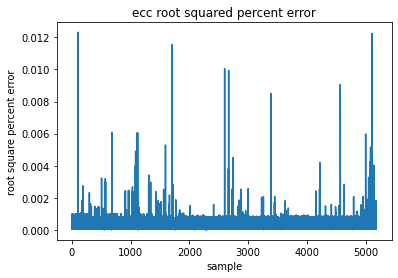

In [ ]:
# the root squared error for ecc
rse_ecc = np.sqrt((preds[:,0] - np.array(df['ecc']))**2)

# the squared error percentage compared to the mean
rse_perc_ecc = (rse_ecc/df['ecc'].mean())*100
plt.plot(rse_perc_ecc)
plt.title('ecc root squared percent error')
plt.ylabel('root square percent error')
plt.xlabel('sample')

# the mean squared error
mse_ecc = mean_squared_error(preds[:,0],np.array(df['ecc']))
print(f'mean squared error: {mse_ecc}')

mean squared error: 562500.0002617456


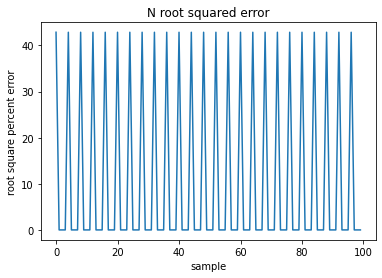

In [ ]:
# the root squared error for N
rse_N = np.sqrt((preds[:,1] - np.array(df['N']))**2)

# the squared error percentage compared to the mean
rse_perc_N = (rse_N/df['N'].mean())*100
plt.plot(rse_perc_N[0:100], '-')
plt.title('N root squared error')
plt.ylabel('root square percent error')
plt.xlabel('sample')

# the mean squared error
mse_N = mean_squared_error(preds[:,1],np.array(df['N']))
print(f'mean squared error: {mse_N}')

mean squared error: 2.7758863901639538e-06


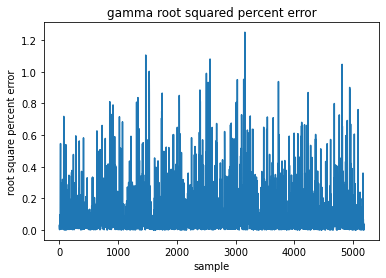

In [ ]:
# the root squared error for gamma
rse_gamma = np.sqrt((preds[:,2] - np.array(df['gammaG']))**2)

# the squared error percentage compared to the mean
rse_perc_gamma = (rse_gamma/df['gammaG'].mean())*100
plt.plot(rse_perc_gamma)
plt.title('gamma root squared percent error')
plt.ylabel('root square percent error')
plt.xlabel('sample')

# the mean squared error
mse_gamma = mean_squared_error(preds[:,2],np.array(df['gammaG']))
print(f'mean squared error: {mse_gamma}')

So for both $e_{cc}$ and $\gamma_G$ the model was very performant, with maximum percent errors of 0.012% and 1.2% w.r.t their mean values, respectively. $N$ was problematic and although most of the error values seem to be very low (~0.2), it very often is wrong on the order of about 1500. Again, I don't know what $N$ is but it might just be that it is a value that isn't strongly correlated with the inputs. Since this is a prototype, it is not worth the effort to try to find a model that could learn a lose correlation like that, instead we will ignore $N$ as predicted variable, and add it to the inputs. This way the next section on tuning is going to be more readable in the future.

In [148]:
# changing parameters for the sake of the prototype's readability
forces, voltages = df[['ecc','gammaG']], df[['N','Esoil','Econc','Dbot','H1','H2','H3','Mr_t','Mt_t','Mr_c','Mt_c']] #Column names are explicity stated for this, instead of the column indices

# displaying forces for a sanity check that we got the correct columns
with pd.option_context('display.max_rows', 10): #setting to show 10 rows
  display(forces)


,ecc,gammaG
0,0,0.9
1,10,0.9
2,18,0.9
3,26,0.9
4,0,0.9
...,...,...
5179,26,1.1
5180,0,1.1
5181,10,1.1
5182,18,1.1


## Tuning
It is worth it to devote some time to tuning after figuring out the general model structure. This can be easily done with `GridSearchCV`. What it does is literally an exhaustive search of all specified parameters to see how they affect the model's predictions. Alternatively, `RandomizedSearchCV` is a better option if there are many parameters to tune, although it might not find the exact best solution, it will find a good enough one in most cases. Knowing what to vary and between what values comes from experience, gut feeling, other people's solutions, and sometimes, if you are lucky, a paper that explored the same type of problem. 

### Training and testing
One more thing to note is the issue of fitting the data. The intention of a machine learning technique is that the model finds a function that represents the real world data, but a model can technically simply fit the data by "copying" the provided datapoints and have a bad representation in between those points (the same way a 7th order polynomial for instance can perfectly fit 3 points, but it doesn't mean that the actual trend the polynomial shows is actually representative of the data).
To avoid this, what is usually done is a random split of the data between 2 new datasets, named "train" and "test" dataset. The train dataset is what the model sees while it is learning the data, and the test dataset is used to see if the model can predict this other set of datapoints it hasn't been exposed to yet. If the model can predict the train dataset but can't predict the testing dataset, it means that it overfitted the data and didn't actually learn a useful pattern. If the model doesn't predict either, it means that it underfitted the data, and doesn't have predictive power. The idea is to find a balance between these two extremes.

In [149]:
## Splitting the data into a training set containint 85% of the data and a test set with the remaining
voltages_train, voltages_test, forces_train, forces_test = train_test_split(
    voltages, forces, test_size=0.15)

## displaying the sized of the training and testing datasets
print(f'The total dataset has {len(voltages)} samples, split into training: {len(voltages_train)} and test: {len(forces_test)}') 

The total dataset has 5184 samples, split into training: 4406 and test: 778


A little notable feature is that because this is a multioutput model, and 
the multioutput aspect is just a wrapper on top of the actual xgboost model, it is not possible to pass the keys of xgboost directly when tuning, instead it is necessary to pass them prefixed by `estimator__`. The need for this can be seen by displaying `model.get_params().keys()` as can be seen in the next cell

In [ ]:
print(model.get_params().keys())

dict_keys(['estimator__base_score', 'estimator__booster', 'estimator__colsample_bylevel', 'estimator__colsample_bynode', 'estimator__colsample_bytree', 'estimator__gamma', 'estimator__importance_type', 'estimator__learning_rate', 'estimator__max_delta_step', 'estimator__max_depth', 'estimator__min_child_weight', 'estimator__missing', 'estimator__n_estimators', 'estimator__n_jobs', 'estimator__nthread', 'estimator__objective', 'estimator__random_state', 'estimator__reg_alpha', 'estimator__reg_lambda', 'estimator__scale_pos_weight', 'estimator__seed', 'estimator__silent', 'estimator__subsample', 'estimator__verbosity', 'estimator', 'n_jobs'])


It is important to note what data is being provided to the model during tuning. While it is desirable that the model be the best at predicting the entire data, we want to avoid overfitting, so we only show it te training data during tuning, and then the model's performane of  the tuned model can be more easily compared against the test dataset. This allows us to determine whether a tuning setting essentially is too much for the dataset we have.

In [150]:
## Redefining the model to have base parameters we'd like 
# simple xgboost regressor
single_model = xgb.XGBRegressor(subsample = 0.7, eval_metric = 'rmse', n_estimators=400, max_depth=5, objective='reg:squarederror', tree_method = 'hist')
# multi output regressor
model = MultiOutputRegressor(single_model)


## creating a dictionary containing all the parameters to be iterated through

tuning_parameters = {
    "estimator__learning_rate": [0.1, 0.01, 0.001],
    "estimator__colsample_bytree": [0.6, 0.8, 1.0],
    "estimator__subsample": [0.6, 0.8, 1.0],
    "estimator__max_depth": [2, 3, 4,6 ,8 ,10],
    "estimator__n_estimators": [100, 200, 300, 400],
    "estimator__reg_lambda": [1, 1.5, 2],
    "estimator__gamma": [0.1, 0.3, 0.5, 0.7],
}

## running the tuning
model_search = RandomizedSearchCV(model, tuning_parameters, scoring = 'explained_variance', verbose = 1)
model_search.fit(voltages_train, forces_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   52.0s finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=MultiOutputRegressor(estimator=XGBRegressor(base_score=0.5,
                                                                         booster='gbtree',
                                                                         colsample_bylevel=1,
                                                                         colsample_bynode=1,
                                                                         colsample_bytree=1,
                                                                         eval_metric='rmse',
                                                                         gamma=0,
                                                                         importance_type='gain',
                                                                         learning_rate=0.1,
                                                                         max_delta_step=0,
                                        

On a tuning object (such as `model_search` in this prototype), the `.cv_results_` method returns a table with all parameter combinations tested and what the results were for whatever metric is used for tuning.

In [151]:
with pd.option_context('display.max_rows', None): #setting to show all rows

  #show only the more relevant columns sorted by rank
  results = pd.DataFrame(model_search.cv_results_)##[['param_estimator__gamma','param_estimator__learning_rate','param_estimator__max_depth','param_estimator__n_estimators','mean_test_score','std_test_score','rank_test_score']]
  results.sort_values(by='rank_test_score', inplace=True)
  display(results)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__subsample,param_estimator__reg_lambda,param_estimator__n_estimators,param_estimator__max_depth,param_estimator__learning_rate,param_estimator__gamma,param_estimator__colsample_bytree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,2.571640,0.109831,0.009331,0.002106,0.8,2,300,10,0.1,0.3,1,"{'estimator__subsample': 0.8, 'estimator__reg_...",0.572864,0.557092,0.560706,0.572347,0.566150,0.565832,0.006239,1
0,3.674375,0.059029,0.011373,0.000960,0.8,2,400,10,0.1,0.3,0.8,"{'estimator__subsample': 0.8, 'estimator__reg_...",0.564267,0.555394,0.566398,0.573077,0.560178,0.563863,0.005946,2
6,0.553438,0.018860,0.009079,0.000424,0.6,1,300,3,0.1,0.5,0.8,"{'estimator__subsample': 0.6, 'estimator__reg_...",0.523874,0.519546,0.522563,0.524494,0.521910,0.522477,0.001729,3
2,0.178995,0.004240,0.007547,0.000582,1,1.5,200,2,0.1,0.7,0.6,"{'estimator__subsample': 1.0, 'estimator__reg_...",0.519703,0.515172,0.515696,0.518360,0.514834,0.516753,0.001928,4
7,0.829175,0.019365,0.025209,0.000790,1,2,400,6,0.01,0.7,0.6,"{'estimator__subsample': 1.0, 'estimator__reg_...",0.516929,0.513689,0.515416,0.516201,0.513443,0.515136,0.001370,5
8,0.635595,0.010093,0.007466,0.000361,0.6,2,200,6,0.1,0.7,0.8,"{'estimator__subsample': 0.6, 'estimator__reg_...",0.513654,0.513791,0.515507,0.515930,0.513046,0.514386,0.001125,6
3,0.787848,0.017148,0.014122,0.001332,0.6,1.5,400,3,0.01,0.7,1,"{'estimator__subsample': 0.6, 'estimator__reg_...",0.510885,0.511157,0.512889,0.512639,0.509686,0.511451,0.001184,7
5,0.531249,0.015185,0.009002,0.000549,0.6,2,200,8,0.01,0.7,0.8,"{'estimator__subsample': 0.6, 'estimator__reg_...",0.498294,0.500278,0.500727,0.499759,0.498055,0.499423,0.001067,8
9,0.328912,0.008275,0.007138,0.000516,0.8,2,200,2,0.001,0.3,1,"{'estimator__subsample': 0.8, 'estimator__reg_...",0.156896,0.154221,0.156556,0.157618,0.156700,0.156398,0.001148,9
4,0.191000,0.005851,0.006118,0.000546,0.6,1,100,4,0.001,0.7,0.8,"{'estimator__subsample': 0.6, 'estimator__reg_...",0.089728,0.090607,0.090219,0.090590,0.090881,0.090405,0.000399,10


In [69]:
print(f'so the best model uses the parameters {model_search.best_params_} for a score of {model_search.best_score_}')

so the best model uses the parameters {'estimator__subsample': 0.6, 'estimator__reg_lambda': 2, 'estimator__n_estimators': 400, 'estimator__max_depth': 10, 'estimator__learning_rate': 0.1, 'estimator__gamma': 0.3, 'estimator__colsample_bytree': 0.6} for a score of 0.23175804956300555


This suggests some good parameters. The rank 1 option uses the maximum number of estimators and a somewhat low gamma, which is a regularization value, so we should be thinking it might be overfitting. Ideally this would be explored, but since this is just a prototype, I'll go with my gut feeling and use the rank 3 parameter setting because it has much higher gammas and a lower number of the parameters that often induce overfitting such as max depth and number of estimators, while still having seemingly just as much predictive power.

In [153]:
## getting the rank 2 parameters
rank = 3
index_of_rank = int(np.where(model_search.cv_results_['rank_test_score'] == rank)[0]) #gets the index of the chosen rank
chosen_parameters = model_search.cv_results_['params'][index_of_rank]

## display chosen parameters
chosen_parameters

{'estimator__colsample_bytree': 0.8,
 'estimator__gamma': 0.5,
 'estimator__learning_rate': 0.1,
 'estimator__max_depth': 3,
 'estimator__n_estimators': 300,
 'estimator__reg_lambda': 1,
 'estimator__subsample': 0.6}

In [ ]:
## Creating a model with the best parameters found
tuned_model = MultiOutputRegressor(xgb.XGBRegressor(objective = 'reg:squarederror'))
tuned_model.set_params(**chosen_parameters);

In [155]:
## Fitting the new model to the training set
tuned_model.fit(voltages_train, forces_train)

MultiOutputRegressor(estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1.0, gamma=0.7,
                                            importance_type='gain',
                                            learning_rate=0.1, max_delta_step=0,
                                            max_depth=4, min_child_weight=1,
                                            missing=None, n_estimators=300,
                                            n_jobs=1, nthread=None,
                                            objective='reg:squarederror',
                                            random_state=0, reg_alpha=0,
                                            reg_lambda=2, scale_pos_weight=1,
                                            seed=None, silent=None,
                                            subsample

In [156]:
## Evaluating the new model's predictions on the test set
# prediction
tuned_preds = tuned_model.predict(voltages_test)
tuned_preds = np.array(tuned_preds)
tuned_preds

array([[2.5972769e+01, 9.9895155e-01],
       [2.5971193e+01, 9.9895155e-01],
       [2.0472258e-02, 9.9895155e-01],
       ...,
       [2.5971193e+01, 9.9895155e-01],
       [2.5972769e+01, 9.9895155e-01],
       [1.7982292e+01, 9.9895155e-01]], dtype=float32)

mean squared error: 0.08303985448234118


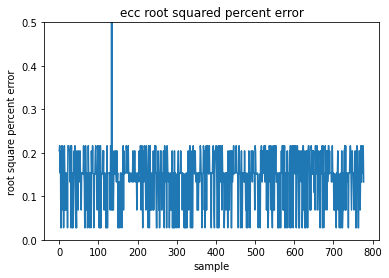

In [161]:
# the root squared error for ecc
rse_ecc = np.sqrt((tuned_preds[:,0] - np.array(forces_test['ecc']))**2)

# the squared error percentage compared to the mean
rse_perc_ecc = (rse_ecc/forces_test['ecc'].mean())*100
plt.plot(rse_perc_ecc)
plt.title('ecc root squared percent error')
plt.ylabel('root square percent error')
plt.xlabel('sample')
plt.ylim([0,0.5])

# the mean squared error
mse_ecc = mean_squared_error(tuned_preds[:,0],np.array(forces_test['ecc']))
print(f'mean squared error: {mse_ecc}')

mean squared error: 0.009401598324273034


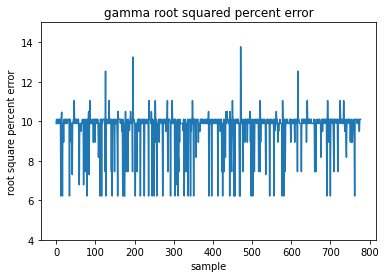

In [169]:
# the root squared error for gamma
rse_gamma = np.sqrt((tuned_preds[:,1] - np.array(forces_test['gammaG']))**2)

# the squared error percentage compared to the mean
rse_perc_gamma = (rse_gamma/forces_test['gammaG'].mean())*100
plt.plot(rse_perc_gamma)
plt.title('gamma root squared percent error')
plt.ylabel('root square percent error')
plt.xlabel('sample')
plt.ylim([4,15])
# the mean squared error
mse_gamma = mean_squared_error(tuned_preds[:,1],np.array(forces_test['gammaG']))
print(f'mean squared error: {mse_gamma}')

So with this model the test set produced percent errors in the 0.2% range for one variable and 6-10% range for the other variable. This might seem like a downgrade from the previous model, but it is necessary to remember that the previous model was trained on all of the data, and therefore its values were probably overfitted. This is a good example and proof of concept of what needs to be done when moving on from the prototype.

## Saving
After finding a good model, it is important to save it for future use. This can be done with `pickle.dump` and `pickle.load`

In [173]:
## saving the model
pkl_filename = "pickle_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(tuned_model, file)

## downloading the model to the computer since we are in a temporary online workspace
from google.colab import files
files.download(pkl_filename) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [176]:
## Loading in model saved to a personal local drive
from google.colab import files
saved_model = files.upload()

Saving pickled_model.pkl to pickled_model.pkl


In [181]:
saved_model_filename = 'pickled_model.pkl'

## loading the model into a "variable"
with open(saved_model_filename, 'rb') as file:
  pickle_model = pickle.load(file)

## display the model that was loaded in
pickle_model

MultiOutputRegressor(estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1.0, gamma=0.7,
                                            importance_type='gain',
                                            learning_rate=0.1, max_delta_step=0,
                                            max_depth=4, min_child_weight=1,
                                            missing=nan, n_estimators=300,
                                            n_jobs=1, nthread=None,
                                            objective='reg:squarederror',
                                            random_state=0, reg_alpha=0,
                                            reg_lambda=2, scale_pos_weight=1,
                                            seed=None, silent=None,
                                            subsample=